In [8]:
import sys
import cv2
import torch
import torch.nn.functional as F
import pandas as pd

sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/src/full_model")
sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/src")
# import sys
sys.path.append("/Users/claire/Desktop/Stuff-/codes/dissertation/cxr/rgrg/")

from full_model.train_full_model import *
from full_model.generate_reports_for_images import *

# load model

In [9]:
checkpoint_path = "/Users/claire/Desktop/Stuff-/codes/dissertation/data/checkpoints/full_model_checkpoint_val_loss_19.793_overall_steps_155252.pt"
model = get_model(checkpoint_path)

print("Model instantiated.")


Model instantiated.


# load data

In [3]:
df = pd.read_csv('/Users/claire/Desktop/Stuff-/codes/dissertation/data/dataset-with-reference-reports/valid.csv')
images_paths = df['mimic_image_file_path']
reports = df['reference_report']
generated_reports = []
bert_score = evaluate.load("bertscore")
sentence_tokenizer = spacy.load("en_core_web_trf")
tokenizer = get_tokenizer()

In [4]:
from full_model.test_set_evaluation import *
raw_test_dataset, raw_test_2_dataset = get_dataset()

    # note that we don't actually need to tokenize anything (i.e. we don't need the input ids and attention mask),
    # because we evaluate the language model on it's generation capabilities (for which we only need the input images)
    # but since the custom dataset and collator are build in a way that they expect input ids and attention mask
    # (as they were originally made for training the model),
    # it's better to just leave it as it is instead of adding unnecessary complexity
tokenizer = get_tokenizer()
tokenized_test_dataset, tokenized_test_2_dataset = get_tokenized_dataset(tokenizer, raw_test_dataset, raw_test_2_dataset)
test_transforms = get_transforms()
test_dataset_complete = CustomDataset("test", tokenized_test_dataset.select(range(5)), test_transforms, log)
test_2_dataset_complete = CustomDataset("test", tokenized_test_2_dataset.select(range(5)), test_transforms, log)
test_loader, test_2_loader = get_data_loaders(tokenizer, test_dataset_complete, test_2_dataset_complete)


[WARNING]: Parameter 'function'=<function get_tokenized_dataset.<locals>.tokenize_function at 0x2a9fd6790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/30804 [00:00<?, ?ex/s]

  0%|          | 0/1173 [00:00<?, ?ex/s]

In [5]:
data = next(iter(test_loader))
print(data.keys())
images = data["images"]
print(images.shape)
image = images[[0]]
print(image.shape)
image_targets = data["image_targets"]
print(image_targets)

dict_keys(['input_ids', 'attention_mask', 'images', 'image_targets', 'region_has_sentence', 'region_is_abnormal', 'reference_sentences', 'reference_reports'])
torch.Size([4, 1, 512, 512])
torch.Size([1, 1, 512, 512])
[{'boxes': tensor([[ 98.,  38., 244., 354.],
        [122.,  50., 244., 162.],
        [114., 162., 240., 232.],
        [ 98., 232., 234., 354.],
        [176., 146., 242., 246.],
        [134.,  38., 244., 112.],
        [ 74., 322., 120., 368.],
        [ 98., 304., 260., 354.],
        [272.,  38., 410., 370.],
        [272.,  50., 396., 162.],
        [276., 162., 400., 236.],
        [276., 236., 410., 370.],
        [274., 146., 338., 250.],
        [274.,  38., 386., 112.],
        [388., 336., 434., 380.],
        [272., 320., 410., 370.],
        [216.,  28., 278., 224.],
        [220.,   0., 280., 508.],
        [ 82.,  60., 240., 112.],
        [280.,  60., 442., 108.],
        [262., 128., 296., 162.],
        [208.,  86., 346., 338.],
        [228.,  86., 296

In [10]:
object_detector = model.object_detector
language_model = model.language_model
print (object_detector.return_feature_vectors, object_detector.training)
predictions  = object_detector(data['images'], data['image_targets'])
            

True False
OrderedDict([('0', tensor([[[[5.4726e+00, 1.4420e+00, 6.1083e-02,  ..., 0.0000e+00,
           0.0000e+00, 6.6087e-01],
          [2.3130e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.2839e-01],
          [9.2833e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.3305e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[7.5487e+00, 2.2160e+00, 3.2769e-01,  ..., 1.8220e-02,
           8.2677e-03, 9.6909e-01],
          [3.6005e+00, 6.9643e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7745e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.0186e-01, 2.3057

In [145]:
images = data['images']

In [146]:
features = object_detector.backbone(images)

In [148]:
features.shape

torch.Size([4, 2048, 16, 16])

In [149]:

targets = data["image_targets"]
images = data['images']
images, features = object_detector._transform_inputs_for_rpn_and_roi(images,targets)


In [155]:

proposals, proposal_losses = object_detector.rpn(images, features, targets)
roi_heads_output = object_detector.roi_heads(features, proposals, images.image_sizes, targets)

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [129]:
features

OrderedDict([('0',
              [{'boxes': tensor([[ 98.,  38., 244., 354.],
                        [122.,  50., 244., 162.],
                        [114., 162., 240., 232.],
                        [ 98., 232., 234., 354.],
                        [176., 146., 242., 246.],
                        [134.,  38., 244., 112.],
                        [ 74., 322., 120., 368.],
                        [ 98., 304., 260., 354.],
                        [272.,  38., 410., 370.],
                        [272.,  50., 396., 162.],
                        [276., 162., 400., 236.],
                        [276., 236., 410., 370.],
                        [274., 146., 338., 250.],
                        [274.,  38., 386., 112.],
                        [388., 336., 434., 380.],
                        [272., 320., 410., 370.],
                        [216.,  28., 278., 224.],
                        [220.,   0., 280., 508.],
                        [ 82.,  60., 240., 112.],
                      

In [12]:
data['images'].shape

torch.Size([4, 1, 512, 512])

In [119]:
features.shape

torch.Size([4, 2048, 16, 16])

In [10]:
object_detector = model.object_detector
language_model = model.language_model
print (object_detector.return_feature_vectors, object_detector.training)
predictions  = object_detector(data['images'], data['image_targets'])


AttributeError: 'collections.OrderedDict' object has no attribute 'shape'

In [30]:
losses, detections, top_region_features, class_detected = predictions

In [34]:
top_region_features

torch.Size([4, 29, 1024])

In [36]:
class_detected.shape

torch.Size([4, 29])

In [32]:
detections.keys()

dict_keys(['top_region_boxes', 'top_scores'])

In [68]:
detections['top_region_boxes'][0].shape
detections['top_scores'][0]

tensor([0.9998, 0.9997, 0.9987, 0.9990, 0.9984, 0.9995, 0.9900, 0.9989, 0.9997,
        0.9995, 0.9956, 0.9964, 0.9952, 0.9994, 0.9885, 0.9993, 0.9997, 0.9967,
        0.9981, 0.9939, 0.0000, 0.9996, 0.9997, 0.0000, 0.9993, 0.0000, 0.9934,
        0.0000, 0.9998], grad_fn=<SelectBackward0>)

In [45]:
detected_boxes = detections["top_region_boxes"]
print(detected_boxes.shape)
predicted_box = detected_boxes[0]
print(predicted_box.shape)

torch.Size([4, 29, 4])
torch.Size([29, 4])


In [46]:
true_box = image_targets[0]['boxes']



In [52]:
# mean Average Precision (mAP) at IoU > 0.4

def calculate_IoU(box1, box2):
    # box1: (4)
    # box2: (4)
    # returns: (1)
    # box1: (x1, y1, x2, y2)
    # box2: (x1, y1, x2, y2)
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

def calculate_mAP(detected_boxes, true_boxes):
    # detected_box: (num_detected_boxes, 4)
    # true_boxes: (num_true_boxes, 4)
    # returns: mAP

    # calculate IoU for each detected box with each true box
    for i in range(len(detected_boxes)):
        iou = calculate_IoU(detected_boxes[i], true_boxes[i])
        print(iou)

calculate_mAP(predicted_box, true_box)



tensor(0.7797, grad_fn=<DivBackward0>)
tensor(0.7428, grad_fn=<DivBackward0>)
tensor(0.7699, grad_fn=<DivBackward0>)
tensor(0.7314, grad_fn=<DivBackward0>)
tensor(0.8120, grad_fn=<DivBackward0>)
tensor(0.7299, grad_fn=<DivBackward0>)
tensor(0.1668, grad_fn=<DivBackward0>)
tensor(0.7609, grad_fn=<DivBackward0>)
tensor(0.7907, grad_fn=<DivBackward0>)
tensor(0.7293, grad_fn=<DivBackward0>)
tensor(0.7300, grad_fn=<DivBackward0>)
tensor(0.7660, grad_fn=<DivBackward0>)
tensor(0.7651, grad_fn=<DivBackward0>)
tensor(0.7142, grad_fn=<DivBackward0>)
tensor(0.9957, grad_fn=<DivBackward0>)
tensor(0.6806, grad_fn=<DivBackward0>)
tensor(0.7316, grad_fn=<DivBackward0>)
tensor(0.7297, grad_fn=<DivBackward0>)
tensor(0.7365, grad_fn=<DivBackward0>)
tensor(0.6272, grad_fn=<DivBackward0>)
tensor(0.9819, grad_fn=<DivBackward0>)
tensor(0.7529, grad_fn=<DivBackward0>)
tensor(0.7529, grad_fn=<DivBackward0>)
tensor(0.8607, grad_fn=<DivBackward0>)
tensor(0.7695, grad_fn=<DivBackward0>)
tensor(0.9771, grad_fn=<D

In [54]:
 classifier_loss_region_selection, selected_regions, selected_region_features = model.binary_classifier_region_selection(
                top_region_features, class_detected, return_loss=True, region_has_sentence=data['region_has_sentence']
            )

In [67]:
selected_regions.shape
print(top_region_features.shape, selected_regions.shape)
top_region_features[selected_regions].shape

torch.Size([4, 29, 1024]) torch.Size([4, 29])


torch.Size([62, 1024])

In [78]:
data['region_is_abnormal']

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False]])

In [91]:
top_region_features.shape

torch.Size([4, 29, 1024])

In [82]:
pred = model.object_detector(data['images'])

OrderedDict([('0', tensor([[[[5.4726e+00, 1.4420e+00, 6.1083e-02,  ..., 0.0000e+00,
           0.0000e+00, 6.6087e-01],
          [2.3130e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.2839e-01],
          [9.2833e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.3305e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[7.5487e+00, 2.2160e+00, 3.2769e-01,  ..., 1.8220e-02,
           8.2677e-03, 9.6909e-01],
          [3.6005e+00, 6.9643e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7745e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.0186e-01, 2.3057e-01, 0.000

In [85]:
losses, detections, top_region_features, class_detected = pred

In [86]:
top_region_features.shape

torch.Size([4, 29, 1024])

In [75]:
selected_regions[0]
# get index for selected_regions== True
selected_regions_index = [np.where(selected_regions[i]==True) for i in range(len(selected_regions))]

In [80]:
top_region_features.shape

torch.Size([4, 29, 1024])

In [74]:
selected_regions

tensor([ True, False,  True,  True,  True,  True,  True, False,  True, False,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
        False,  True,  True, False,  True, False, False, False, False])

In [76]:
selected_regions_index

[(array([ 0,  2,  3,  4,  5,  6,  8, 11, 12, 13, 14, 17, 18, 19, 21, 22, 24]),),
 (array([ 0,  2,  3,  4,  5,  6,  8, 12, 17, 18, 19, 21, 22, 24]),),
 (array([ 0,  2,  3,  4,  5,  8, 10, 11, 12, 17, 18, 21, 22, 24]),),
 (array([ 0,  1,  2,  3,  4,  8, 10, 11, 12, 17, 21, 22, 24]),)]

In [70]:
sum(sum(selected_regions))

tensor(62)

In [62]:
selected_region_features.shape

torch.Size([62, 1024])

In [55]:
print(classifier_loss_region_selection)

tensor(0.6830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
plt.imshow(image_tensor.squeeze(0).squeeze(0))

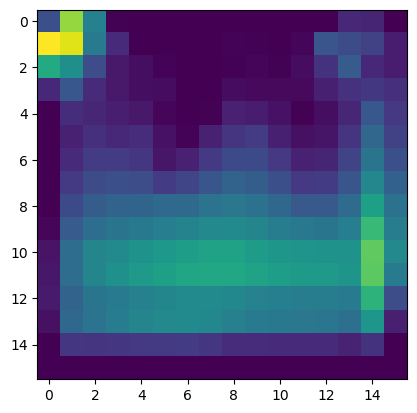

In [33]:
import matplotlib.pyplot as plt
plt.imshow(features[0][0].detach().numpy())

In [12]:
output_ids_full, selected_regions_full, detections_full, class_detected_full = model.generate(images)

    

OrderedDict([('0', tensor([[[[5.4726e+00, 1.4420e+00, 6.1083e-02,  ..., 0.0000e+00,
           0.0000e+00, 6.6087e-01],
          [2.3130e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.2839e-01],
          [9.2833e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.3305e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[7.5487e+00, 2.2160e+00, 3.2769e-01,  ..., 1.8220e-02,
           8.2677e-03, 9.6909e-01],
          [3.6005e+00, 6.9643e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.7745e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.0186e-01, 2.3057e-01, 0.000

In [19]:
print(output_ids_full.shape)
output_ids_full

torch.Size([58, 28])


tensor([[50256,   464, 21726,  ...,  1429,    13, 50256],
        [50256,  1858,   318,  ..., 50256, 50256, 50256],
        [50256,  1858,   318,  ..., 50256, 50256, 50256],
        ...,
        [50256,   464,  2657,  ..., 50256, 50256, 50256],
        [50256,   464, 16957,  ..., 50256, 50256, 50256],
        [50256,   464,  2612,  ..., 50256, 50256, 50256]])

In [16]:


generated_sents_for_selected_regions = tokenizer.batch_decode(
    output_ids_full, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

In [18]:
len(generated_sents_for_selected_regions)

58

In [17]:
generated_sents_for_selected_regions

['The lungs are clear. No pleural effusion or pneumothorax is seen. No acute cardiopulmonary process.',
 'There is no evidence of pneumonia or pleural effusion.',
 'There is mild bibasilar atelectasis.',
 'The mediastinal and hilar contours are normal.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'No pleural effusion or pneumothorax is seen.',
 'The lungs are clear. No acute cardiopulmonary process.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'The mediastinal and hilar contours are normal.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'No pleural effusion or pneumothorax is seen.',
 'No acute osseous abnormalities.',
 'No acute osseous abnormalities.',
 'No acute osseous abnormalities.',
 'The cardiomediastinal silhouette is within normal limits. No acute cardiopulmonary process.',
 'The cardiomediastinal silhouette is normal.',
 'The cardiomediastinal silhouette is normal.',
 'The lungs are clear. No pleural effusion or

In [82]:
reference_sents_for_selected_regions = get_ref_sentences_for_selected_regions(
    data['reference_sentences'], selected_regions_full
)

In [83]:
(
    gen_sents_for_normal_selected_regions,
    gen_sents_for_abnormal_selected_regions,
    ref_sents_for_normal_selected_regions,
    ref_sents_for_abnormal_selected_regions,
) = get_sents_for_normal_abnormal_selected_regions(data['region_is_abnormal'], selected_regions_full, generated_sents_for_selected_regions, reference_sents_for_selected_regions)

In [91]:
len(generated_sents_for_selected_regions)
sum(sum(selected_regions_full))

tensor(58)

In [105]:
np.sum(selected_regions_full[0].numpy())

17

In [106]:
generated_reports, removed_similar_generated_sentences = get_generated_reports(
    generated_sents_for_selected_regions,
    selected_regions_full.numpy(),
    sentence_tokenizer,
    BERTSCORE_SIMILARITY_THRESHOLD
)

[ True False  True  True  True  True  True False  True False False  True
  True  True  True False False  True  True  True False  True  True False
  True False False False False]


/Users/claire/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[ True False  True  True  True  True  True False  True False False False
  True False False False False  True  True  True False  True  True False
  True False False False False]
[ True False  True  True  True  True False False  True False  True  True
  True False False False False  True  True False False  True  True False
  True False False False False]
[ True  True  True  True  True False False False  True False  True  True
  True False False False False  True False False False  True  True False
  True False False False False]


In [108]:
selected_regions_full

tensor([[ True, False,  True,  True,  True,  True,  True, False,  True, False,
         False,  True,  True,  True,  True, False, False,  True,  True,  True,
         False,  True,  True, False,  True, False, False, False, False],
        [ True, False,  True,  True,  True,  True,  True, False,  True, False,
         False, False,  True, False, False, False, False,  True,  True,  True,
         False,  True,  True, False,  True, False, False, False, False],
        [ True, False,  True,  True,  True,  True, False, False,  True, False,
          True,  True,  True, False, False, False, False,  True,  True, False,
         False,  True,  True, False,  True, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False,  True, False,
          True,  True,  True, False, False, False, False,  True, False, False,
         False,  True,  True, False,  True, False, False, False, False]])

In [112]:
sum(sum(data['region_has_sentence'] == selected_regions_full))

tensor(73)

In [117]:
data['reference_reports']

['There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral\n nodular opacities that most likely represent nipple shadows. The\n cardiomediastinal silhouette is normal.  Clips project over the left lung,\n potentially within the breast. The imaged upper abdomen is unremarkable.\n Chronic deformity of the posterior left sixth and seventh ribs are noted.',
 'The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature\n is normal.  Lungs are clear. No pleural effusion or pneumothorax is present.\n Multiple clips are again seen projecting over the left breast.  Remote\n left-sided rib fractures are also re- demonstrated.',
 'Single frontal view of the chest provided.\n \n There is no focal consolidation, effusion, or pneumothorax. The\n cardiomediastinal silhouette is normal.  Again seen are multiple clips\n projecting over the left breast and remote left-sided rib fractures.  No free\n air below the right hemidiaphragm is seen.',
 'Single frontal view

In [107]:
generated_reports


['The lungs are clear. No acute cardiopulmonary process. There is no evidence of pneumonia or pleural effusion. There is mild bibasilar atelectasis. The mediastinal and hilar contours are normal. There is no focal consolidation, effusion, or pneumothorax. No acute osseous abnormalities. The cardiomediastinal silhouette is within normal limits.',
 'The lungs are clear. No acute cardiopulmonary process. The right lower lobe is clear. There is a linear opacity in the right lower lobe, which may represent atelectasis. The mediastinal and hilar contours are normal. There is no focal consolidation, effusion, or pneumothorax. No acute osseous abnormalities. The cardiomediastinal silhouette is within normal limits.',
 'The lungs are clear. The mediastinal and hilar contours are unremarkable. There is no focal consolidation, effusion, or pneumothorax. There is no pneumothorax. There is a left lower lobe opacity consistent with pneumonia. There is a small left pleural effusion. There is no pulmo

In [ ]:
generated_sents_for_selected_regions = tokenizer.batch_decode(
    beam_search_output, skip_special_tokens=True, clean_up_tokenization_spaces=True
)  # list[str]

generated_report = convert_generated_sentences_to_report(
    generated_sents_for_selected_regions, bert_score, sentence_tokenizer
)  # str

# experiment with language model

In [ ]:
_, detections, top_region_features, class_detected = object_detector(images)



# selected_region_features is of shape [num_regions_selected_in_batch x 1024]
# selected_regions is of shape [batch_size x 29] and is True for regions that should get a sentence
# (it has exactly num_regions_selected_in_batch True values)
selected_regions, selected_region_features = model.binary_classifier_region_selection(
    top_region_features, class_detected, return_loss=False
)



In [59]:
regions = list(ANATOMICAL_REGIONS.keys())
print(regions)
# slice the regions based on selected_regions[0]
sub_regions = [regions[i] for i in range(len(regions)) if selected_regions[0][i]]

['right lung', 'right upper lung zone', 'right mid lung zone', 'right lower lung zone', 'right hilar structures', 'right apical zone', 'right costophrenic angle', 'right hemidiaphragm', 'left lung', 'left upper lung zone', 'left mid lung zone', 'left lower lung zone', 'left hilar structures', 'left apical zone', 'left costophrenic angle', 'left hemidiaphragm', 'trachea', 'spine', 'right clavicle', 'left clavicle', 'aortic arch', 'mediastinum', 'upper mediastinum', 'svc', 'cardiac silhouette', 'cavoatrial junction', 'right atrium', 'carina', 'abdomen']


In [61]:
len(sub_regions)

17

In [49]:
selected_regions.shape

torch.Size([4, 29])

The lungs are clear. No pleural effusion or pneumothorax is seen. No acute cardiopulmonary process.
right lung


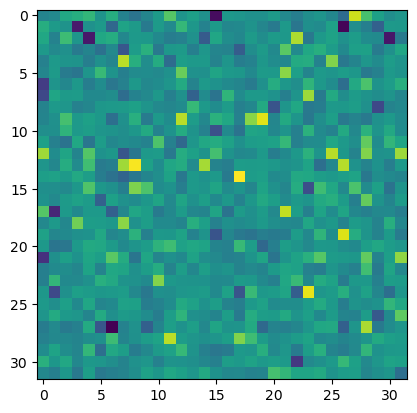

There is no evidence of pneumonia or pleural effusion.
right mid lung zone


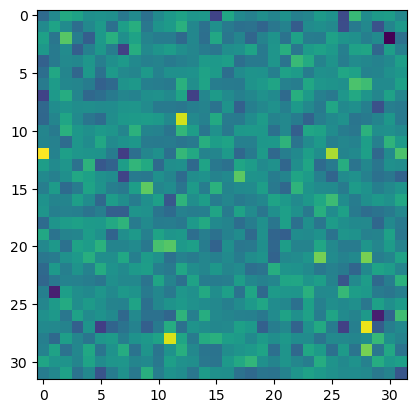

There is mild bibasilar atelectasis.
right lower lung zone


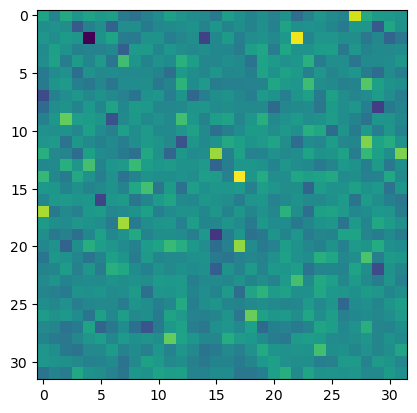

The mediastinal and hilar contours are normal.
right hilar structures


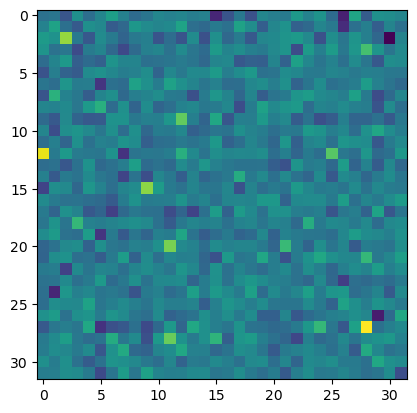

There is no focal consolidation, effusion, or pneumothorax.
right apical zone


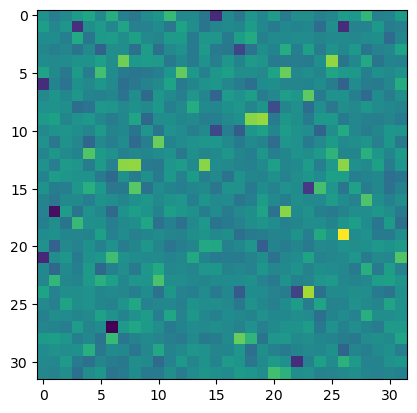

No pleural effusion or pneumothorax is seen.
right costophrenic angle


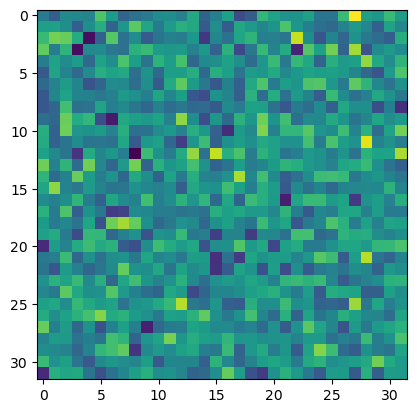

The lungs are clear. No acute cardiopulmonary process.
left lung


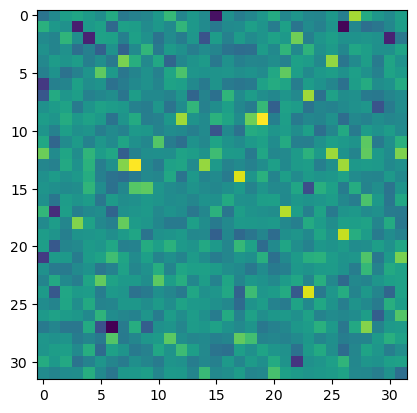

There is no focal consolidation, effusion, or pneumothorax.
left lower lung zone


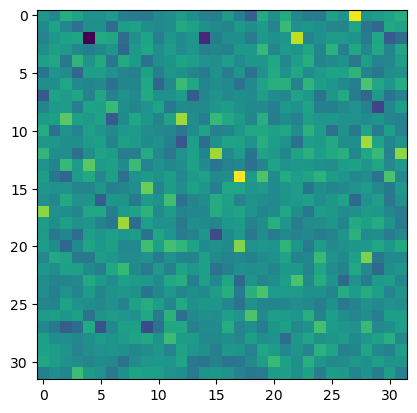

The mediastinal and hilar contours are normal.
left hilar structures


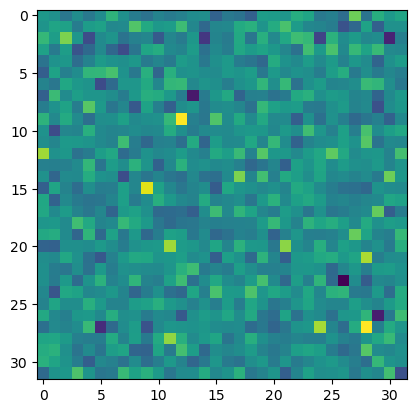

There is no focal consolidation, effusion, or pneumothorax.
left apical zone


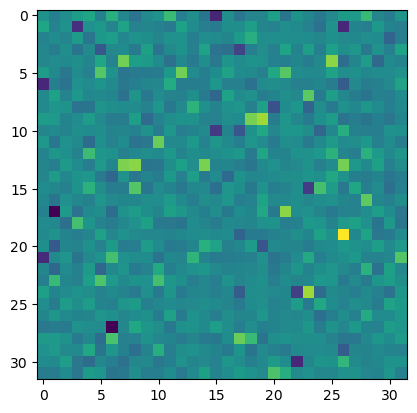

No pleural effusion or pneumothorax is seen.
left costophrenic angle


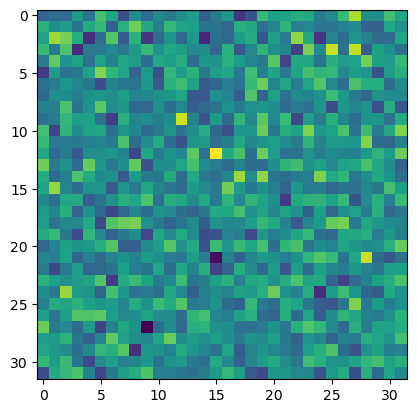

No acute osseous abnormalities.
spine


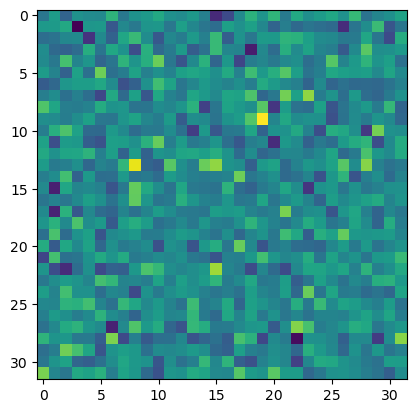

No acute osseous abnormalities.
right clavicle


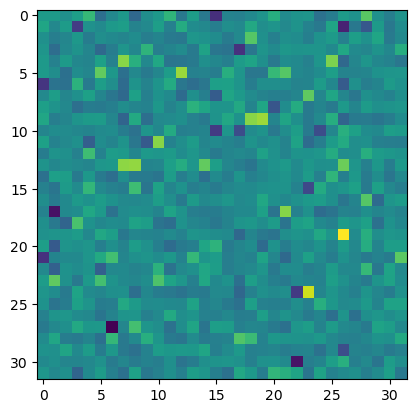

No acute osseous abnormalities.
left clavicle


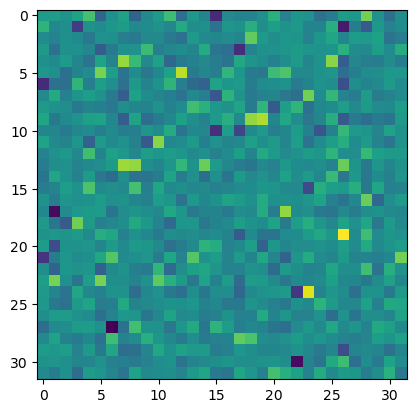

The cardiomediastinal silhouette is within normal limits. No acute cardiopulmonary process.
mediastinum


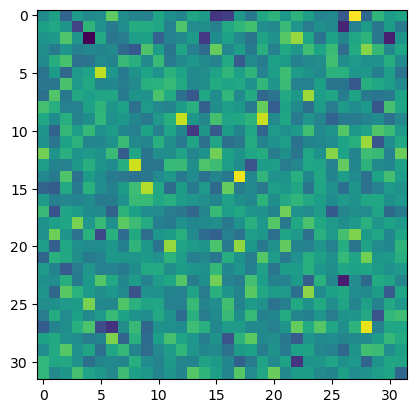

The cardiomediastinal silhouette is normal.
upper mediastinum


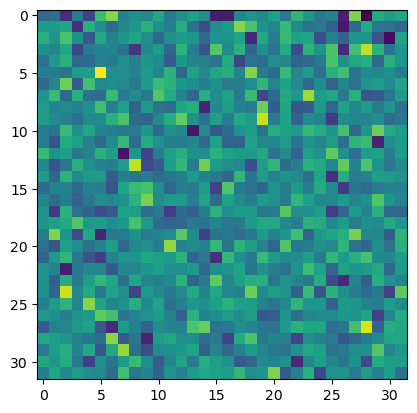

The cardiomediastinal silhouette is normal.
cardiac silhouette


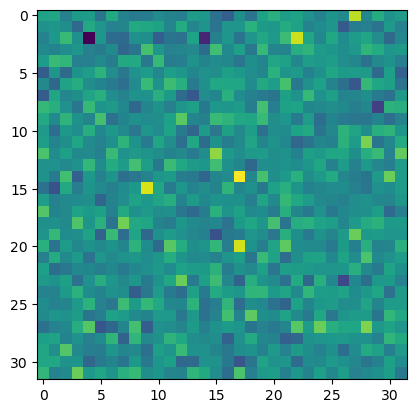

In [62]:
# viz selected_region_features as a heatmap
import matplotlib.pyplot as plt
# convert selected_region_features[0] to a 32x32 image
for i in range(17):
    selected_region_features0 = selected_region_features[i].reshape(32, 32)
    print(generated_sents_for_selected_regions[i])
    print(sub_regions[i])
    plt.imshow(selected_region_features0.detach().numpy())
    plt.show()

In [25]:
selected_region_features[[0]].shape

torch.Size([1, 1024])

In [43]:
output_ids = language_model.generate(
    selected_region_features
)

In [29]:
output_ids

tensor([[50256,   464, 21726,   389,  1598,    13,  1400,  3339,  1523,   914,
          4241,   393, 29631,   849,   273,   897,   318,  1775,    13,  1400,
         14352,  2657, 14922,   377, 36639,  1429,    13, 50256]])

In [46]:

generated_sents_for_selected_regions = tokenizer.batch_decode(
    output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
generated_sents_for_selected_regions

['The lungs are clear. No pleural effusion or pneumothorax is seen. No acute cardiopulmonary process.',
 'There is no evidence of pneumonia or pleural effusion.',
 'There is mild bibasilar atelectasis.',
 'The mediastinal and hilar contours are normal.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'No pleural effusion or pneumothorax is seen.',
 'The lungs are clear. No acute cardiopulmonary process.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'The mediastinal and hilar contours are normal.',
 'There is no focal consolidation, effusion, or pneumothorax.',
 'No pleural effusion or pneumothorax is seen.',
 'No acute osseous abnormalities.',
 'No acute osseous abnormalities.',
 'No acute osseous abnormalities.',
 'The cardiomediastinal silhouette is within normal limits. No acute cardiopulmonary process.',
 'The cardiomediastinal silhouette is normal.',
 'The cardiomediastinal silhouette is normal.',
 'The lungs are clear. No pleural effusion or

# Evaluation

In [11]:
raw_test_dataset_slice1 = raw_test_dataset[:100]
raw_test_2_dataset_slice1 = raw_test_2_dataset[:100]

In [14]:
tokenizer = get_tokenizer()
tokenized_test_dataset, tokenized_test_2_dataset = get_tokenized_dataset(tokenizer, raw_test_dataset, raw_test_2_dataset)
test_transforms = get_transforms()

  0%|          | 0/30804 [00:00<?, ?ex/s]

KeyboardInterrupt: 

In [19]:
type(tokenized_test_dataset.select(range(100)))


datasets.arrow_dataset.Dataset

In [22]:


# model = get_model()

# evaluate_model_on_test_set(model, test_loader, test_2_loader, tokenizer)

In [44]:
test_loader.dataset[0]

{'image': tensor([[[-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596],
          [-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596],
          [-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596],
          ...,
          [-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596],
          [-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596],
          [-1.5596, -1.5596, -1.5596,  ..., -1.5596, -1.5596, -1.5596]]]),
 'bbox_coordinates': tensor([[ 49.,  19., 122., 177.],
         [ 61.,  25., 122.,  81.],
         [ 57.,  81., 120., 116.],
         [ 49., 116., 117., 177.],
         [ 88.,  73., 121., 123.],
         [ 67.,  19., 122.,  56.],
         [ 37., 161.,  60., 184.],
         [ 49., 152., 130., 177.],
         [136.,  19., 205., 185.],
         [136.,  25., 198.,  81.],
         [138.,  81., 200., 118.],
         [138., 118., 205., 185.],
         [137.,  73., 169., 125.],
         [137.,  19., 193.,  56.],
         [194., 168., 217., 190

[tensor(122.), tensor(50.), tensor(244.), tensor(162.)]


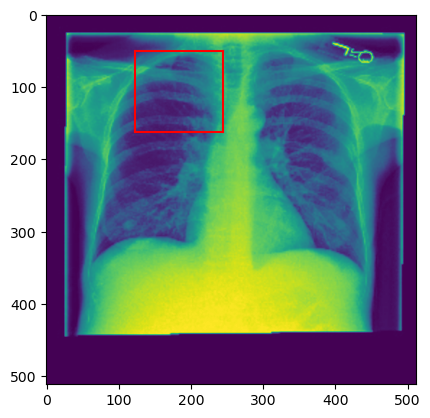

In [52]:
image1 = test_loader.dataset[0]['image']
box1 = test_loader.dataset[0]['bbox_coordinates']

image1 = image1.squeeze(0)
box_coords = box1[1]
box_coords = [x * 2 for x in box_coords]
print(box_coords)
# show image and box on image1
plt.imshow(image1)
plt.plot([box_coords[0], box_coords[0]], [box_coords[1], box_coords[3]], color='red')
plt.plot([box_coords[2], box_coords[2]], [box_coords[1], box_coords[3]], color='red')
plt.plot([box_coords[0], box_coords[2]], [box_coords[1], box_coords[1]], color='red')
plt.plot([box_coords[0], box_coords[2]], [box_coords[3], box_coords[3]], color='red')



In [8]:
model = get_model()

In [23]:
evaluate_model_on_test_set(model, test_loader, test_2_loader, tokenizer)

[INFO]: Test loader: computing scores for object detector, region selection and region abnormal module...


0it [00:00, ?it/s]

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


1it [00:01,  1.38s/it]

torch.Size([1, 512, 512])


2it [00:01,  1.17it/s]
[INFO]: Test loader: computing scores for object detector, region selection and region abnormal module... DONE.
[INFO]: Test loader 2: computing scores for object detector, region selection and region abnormal module...
0it [00:00, ?it/s]

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


1it [00:01,  1.12s/it]

torch.Size([1, 512, 512])


2it [00:01,  1.41it/s]
[INFO]: Test loader 2: computing scores for object detector, region selection and region abnormal module... DONE.
[INFO]: Test loader: generating sentences/reports...
0it [00:00, ?it/s]

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


1it [01:44, 104.13s/it]

torch.Size([1, 512, 512])


2it [01:55, 57.91s/it] 
[INFO]: Test loader: generating sentences/reports... DONE.
[INFO]: Test loader 2: generating sentences/reports...
0it [00:00, ?it/s]

torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


1it [00:32, 32.25s/it]

torch.Size([1, 512, 512])


2it [00:46, 23.05s/it]
[INFO]: Test loader 2: generating sentences/reports... DONE.
[INFO]: Computing language_model_scores...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{'testlen': 689, 'reflen': 583, 'guess': [689, 679, 669, 659], 'correct': [245, 106, 52, 25]}
ratio: 1.1818181818161546


BrokenPipeError: [Errno 32] Broken pipe

In [27]:
from pycocoevalcap.meteor.meteor import Meteor
from full_model.evaluate_full_model.evaluate_language_model import *

In [29]:
nlg_metrics = ["meteor"]

nlg_scores = compute_NLG_scores(nlg_metrics, 'gen_reports', 'ref_reports')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


BrokenPipeError: [Errno 32] Broken pipe